## Reading in Data from Snowflake

In [1]:
#import snowpark and dependencies
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *

import pandas as pd

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt

%matplotlib inline
import datetime as dt
import numpy as np
import seaborn as sns
from cycler import cycler
from scipy.stats import pearsonr
import matplotlib as mpl
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from scipy import stats
from matplotlib.cm import ScalarMappable

plt.style.use(['default', 'seaborn-dark-palette'])
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
plt.rc('axes',
       axisbelow=True)

plt.rc('lines', linewidth=2)

#Snowflake connection info is saved in config.py
from config import snowflake_conn_prop


# lets import some tranformations functions
from snowflake.snowpark.functions import udf, col, lit, translate, is_null, iff

In [2]:
from snowflake.snowpark import version
print(version.VERSION)
session = Session.builder.configs(snowflake_conn_prop).create()

session.sql("use role pattybolan").collect()
session.sql("use database sandbox".format(snowflake_conn_prop['database'])).collect()
session.sql("use schema pattybolan".format(snowflake_conn_prop['schema'])).collect()

print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

(0, 7, 0)
[Row(CURRENT_WAREHOUSE()='HUMANS', CURRENT_DATABASE()='SANDBOX', CURRENT_SCHEMA()='PATTYBOLAN')]


In [3]:
df = session.sql("SELECT * FROM LATENCY_DENSITYRANGE_JAN2022")
df.count()

18092377

In [4]:
df_pd = df.toPandas()

## Latency as a Function of Task Density per Deployment

In [5]:
#For each deployment, look at tasks per minute vs median latency that minute
df_pd

TASK_TS  TASK_LATENCY                    DEPLOYMENT  MON  \
0         2022-01-04 21:15         5.051           frozen-gravity-7083    1   
1         2022-01-11 16:45         5.051           infrared-phase-9556    1   
2         2022-01-12 05:07         5.051        quasarian-isotope-3420    1   
3         2022-01-24 22:31         5.051           frozen-gravity-7083    1   
4         2022-01-16 21:31         5.051           frozen-gravity-7083    1   
...                    ...           ...                           ...  ...   
18092372  2022-01-02 03:34         3.262         desolate-transit-7870    1   
18092373  2022-01-24 15:01         3.262               lunar-nova-0800    1   
18092374  2022-01-19 11:02         3.262      galactian-blueshift-1932    1   
18092375  2022-01-03 10:03         3.262  transparent-protoplanet-2691    1   
18092376  2022-01-19 20:30         3.262      galactian-blueshift-1932    1   

          TASKS EXECUTOR  SCHEDULERS          DENSITY_BIN  
0           611   Celery           2        j) 200+ tasks  
1           173   Celery           2  i) 101 to 200 tasks  
2            55   Celery           1  h)  51 to 100 tasks  
3           374   Celery           2        j) 200+ tasks  
4           398   Celery           2        j) 200+ tasks  
...         ...      ...         ...                  ...  
18092372     55   Celery           1  h)  51 to 100 tasks  
18092373    106   Celery           1  i) 101 to 200 tasks  
18092374    335   Celery           2        j) 200+ tasks  
18092375      4   Celery           1  b)   3 to   5 tasks  
18092376    551   Celery           2        j) 200+ tasks  

[18092377 rows x 8 columns]

In [6]:
#Create a dictionary of dataframes separated by deployment

Deps = df_pd.DEPLOYMENT.unique()
DepsDict = {elem : pd.DataFrame() for elem in Deps}

for key in DepsDict.keys():
    DepsDict[key] = df_pd[:][df_pd.DEPLOYMENT == key]

len(DepsDict)

206

No binning

In [7]:
import seaborn as sns
sns.set_theme(style="whitegrid")

def violin_density(dep):
    DepsDict[dep]=DepsDict[dep][(np.abs(stats.zscore(DepsDict[dep]['TASK_LATENCY'])) < 3)]
    DepsDict[dep]=DepsDict[dep][(np.abs(stats.zscore(DepsDict[dep]['TASKS'])) < 3)]
    x = np.array(DepsDict[dep].TASKS).reshape(-1, 1)
    y = DepsDict[dep].TASK_LATENCY
    
    model_lr  = LinearRegression().fit(x,y)
    r_sq_lr = model_lr.score(x,y)
    intercept_lr = model_lr.intercept_
    slope_lr     = model_lr.coef_
    
    xran = np.arange(np.max(DepsDict[dep].TASKS)+1)
    ax = sns.violinplot(x=DepsDict[dep].TASKS, y=DepsDict[dep].TASK_LATENCY)
    plt.plot(xran-1, (xran-1)*slope_lr+intercept_lr, color='red', linestyle='--', label = 'y ='+str(slope_lr)[1:6]+'x+'+str(intercept_lr)[:4])
    plt.xlabel('Tasks per Minute')
    plt.ylabel('Median Latency per Minute')
    plt.title(dep)
    plt.xticks(np.arange(0, len(xran), 2))
    #plt.ylim(-5,10)
    #plt.xlim(0,15)
    print(np.max(DepsDict[dep].TASKS))
    #plt.savefig('Figures/violinplotexample.png')
    plt.legend()
    plt.show()

183


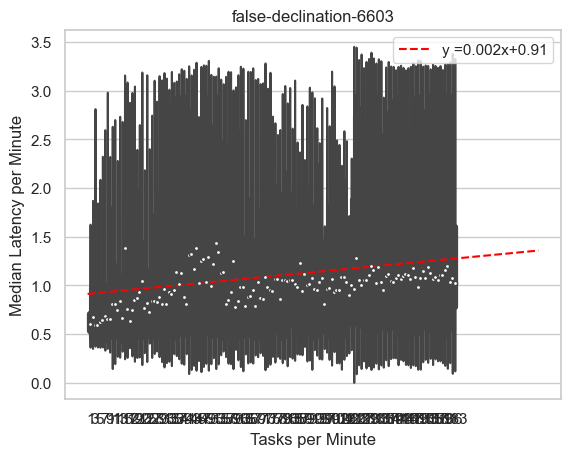

None


In [8]:
print(violin_density('false-declination-6603'))

In [9]:
lens=[]
for index, key in enumerate(DepsDict):
    print(key, DepsDict[key].EXECUTOR.unique(), DepsDict[key].DENSITY_BIN.unique(), DepsDict[key].TASKS.unique(), len(DepsDict[key].TASKS.unique()))
    lens.append(len(DepsDict[key].TASKS.unique()))

frozen-gravity-7083 ['Celery'] ['j) 200+ tasks' 'i) 101 to 200 tasks' 'h)  51 to 100 tasks'
 'e)  16 to  20 tasks' 'g)  31 to  50 tasks' 'd)  11 to  15 tasks'
 'f)  21 to  30 tasks' 'b)   3 to   5 tasks' 'a)   0 to   2 tasks'
 'c)   6 to  10 tasks'] [611 374 398 425 402 232 386 518 724 682 653 415 360 727 439 630 448 103
 526 496 462 432 565 562 212 411 400 405 575 603 447 430 695 459 651 709
 600 434 706 514 754 681 426 578 556 427 550 629 566 413 580 458 414 619
 433 471 399 240 359 694 375 418 595 588 473 491 446 621 627 474 761 421
 171 393 391 373 510 675 680 517 470  58 407 643 501 406 683 542 576 461
 669 725 228 602 449 571 250 428  86 419 468 572 717 513  19 452 652 450
 644 616 320 396 267 214 410 689 765 555 633 492 463 345 569 412 342 608
 515 477 363 739 637 265 631 409 445 649 404 388 324 615 632 260 401 685
 622 423 420 766 443 211 591 435 792 563 429 372 478 442 707 604 639 348
 356 626 705 403 437 582 243 349 581 416 377 607 735 774 598 650 361 596
 431 467 465 397 295

lunar-nova-0800 ['Celery'] ['f)  21 to  30 tasks' 'h)  51 to 100 tasks' 'g)  31 to  50 tasks'
 'i) 101 to 200 tasks' 'e)  16 to  20 tasks' 'd)  11 to  15 tasks'
 'c)   6 to  10 tasks' 'a)   0 to   2 tasks' 'b)   3 to   5 tasks'] [ 29  64  47 104  18  39  90  35  75  99  88  40  91  21  36  78  68  96
  95  13 100  85  54  87  93  24  57  69  41  73 103  92  32  20  63  65
  62  44  17  55 102 105 111 101  46  28  74  66  94  84  49  27  31  60
  58  89 112  97  79 109  12  81  37  98  43  67  22 107  11  23  30  15
  52  56  53 106  34  42  25  72  71  19  86  45 108  83  26  48  50  82
  33  16  38  77  61   9  70  76  14  59  80  10  51 113   7 116 114 122
 110 121   2   6 115 117 120   4 119 124   8 132 118   1   5 128   3 131
 123 125 133 129 126 130 127] 133
galactian-blueshift-1932 ['Celery'] ['j) 200+ tasks' 'i) 101 to 200 tasks' 'g)  31 to  50 tasks'
 'h)  51 to 100 tasks' 'd)  11 to  15 tasks' 'f)  21 to  30 tasks'
 'e)  16 to  20 tasks' 'c)   6 to  10 tasks' 'b)   3 to   5 ta

desolate-transit-7870 ['Celery'] ['h)  51 to 100 tasks' 'g)  31 to  50 tasks' 'i) 101 to 200 tasks'
 'd)  11 to  15 tasks' 'c)   6 to  10 tasks' 'e)  16 to  20 tasks'
 'f)  21 to  30 tasks' 'b)   3 to   5 tasks' 'a)   0 to   2 tasks'] [ 77  69  59  63  50  47  45  73 122  84 121  43 124  39 120  46  12  80
  67  68  87  51 118  96 123  55 111 135  57  92  78 103  38  82 102  88
  62  49  64  52  91  41  58  93 133  70  74  98  54  85 140  60 109  56
   6  61  89  48  90  83 113  71  75 108  81  97  65 126  17 119   9 125
  42 130  53  76 112 101  95  99 129 105  72 100 127  10  19  26  66  86
 104 106 115  40  94  79 110  37 114 116 136 107  44  35 137 138 117 131
  36  22 143  34 132 134  18  31 128 142  11   7  16   8 144   4  14  32
  23   5  27  15   2  24  13  33  30   3  21  28 161  25  20   1 148 166
  29 184 145] 147
blazing-ray-3043 ['Celery'] ['d)  11 to  15 tasks' 'f)  21 to  30 tasks' 'e)  16 to  20 tasks'
 'c)   6 to  10 tasks' 'b)   3 to   5 tasks' 'a)   0 to   2 tasks'] 

descriptive-intensity-5447 ['Celery'] ['a)   0 to   2 tasks' 'b)   3 to   5 tasks' 'e)  16 to  20 tasks'
 'd)  11 to  15 tasks' 'f)  21 to  30 tasks' 'g)  31 to  50 tasks'
 'c)   6 to  10 tasks'] [ 2  1  3  4 17 13 20 18 29 19 37 14 15 21 11  5 12  9  8 10  6  7 16 22] 24
exact-cosmology-6334 ['Kubernetes'] ['a)   0 to   2 tasks' 'b)   3 to   5 tasks' 'c)   6 to  10 tasks'
 'd)  11 to  15 tasks' 'e)  16 to  20 tasks' 'f)  21 to  30 tasks'
 'g)  31 to  50 tasks'] [ 1  5  9  2  3  8 10  4 12  7 11  6 13 16 14 21 17 15 18 19 20 39] 22
spherical-constellation-5573 ['Celery'] ['a)   0 to   2 tasks' 'b)   3 to   5 tasks' 'h)  51 to 100 tasks'
 'i) 101 to 200 tasks' 'd)  11 to  15 tasks' 'e)  16 to  20 tasks'
 'c)   6 to  10 tasks' 'f)  21 to  30 tasks'] [  2   3  66 103  71  73  11  67  69  20 106  75  61  70  77  68  72   4
  74 101  56 104  63  55  62  17  76   6  12  23  15   1  10  14  19  13
   5   7   9  16  18  21   8] 43
universal-antimatter-5677 ['Local' 'Celery'] ['b)   3 to   5 ta

positional-constellation-9271 ['Local'] ['a)   0 to   2 tasks' 'b)   3 to   5 tasks'] [1 2 3] 3
ancient-bolometer-2732 ['Local'] ['d)  11 to  15 tasks' 'e)  16 to  20 tasks' 'a)   0 to   2 tasks'
 'b)   3 to   5 tasks'] [11 14 17  1  2 13  3  4] 8
modern-mass-7417 ['Local'] ['d)  11 to  15 tasks' 'c)   6 to  10 tasks' 'b)   3 to   5 tasks'] [11  8  4] 3
traditional-ellipse-7686 ['Celery' 'Local'] ['d)  11 to  15 tasks' 'b)   3 to   5 tasks' 'c)   6 to  10 tasks'
 'a)   0 to   2 tasks'] [15  3 10  1  4  2] 6
advanced-conjunction-6005 ['Local'] ['b)   3 to   5 tasks' 'd)  11 to  15 tasks' 'c)   6 to  10 tasks'
 'a)   0 to   2 tasks'] [ 4  3 15  9  1  2  8  7  5  6] 10
nuclear-elliptical-9752 ['Local'] ['c)   6 to  10 tasks' 'a)   0 to   2 tasks' 'b)   3 to   5 tasks'] [6 2 4] 3
spherical-magnitude-0710 ['Celery'] ['c)   6 to  10 tasks' 'b)   3 to   5 tasks' 'a)   0 to   2 tasks'] [10  4  2  6  1  5  3] 7
frozen-pulsar-8414 ['Local'] ['b)   3 to   5 tasks' 'a)   0 to   2 tasks'] [4 1] 2
m

In [10]:
print((DepsDict['cislunar-microwave-0350'].groupby('DENSITY_BIN').size()).to_list())

[491, 4348, 804, 194, 450, 1270]


# Binning Scheme 
Define a number of bins for each deployment based on how many individual tasks per minute values they have. For each bin, use the mean tasks per minute in that bin to define the "tasks per minute" value of that bin. 

We will use a qcut to make 10 bins per deployment, but only for tasks that have greater than 10 unique tasks per minute values.

## Practice on one deployment to start

In [12]:
def violin_density_binned(dep):
    fig, ax = plt.subplots()
    #DepsDict[dep]=DepsDict[dep][(np.abs(stats.zscore(DepsDict[dep]['TASK_LATENCY'])) < 5)]
    #DepsDict[dep]=DepsDict[dep][(np.abs(stats.zscore(DepsDict[dep]['TASKS'])) < 5)]
    DepsDict[dep]['bins'] = pd.qcut(DepsDict[dep]['TASKS'], q=10, duplicates='drop')
    
    tasks=(DepsDict[dep].groupby('bins').mean()['TASKS'])
    bins_list = sorted(DepsDict[dep].bins.unique())
    #print(bins_list, tasks)
    
    tasks_mean=[]
    for i in range(len(DepsDict[dep])):
        for j in range(len(bins_list)):
            if (DepsDict[dep].bins.iloc[i] == bins_list[j]):
                tasks_mean.append(tasks[j])
    
    DepsDict[dep]['tasks_mean'] = tasks_mean

    x = np.array(sorted(DepsDict[dep].tasks_mean.unique())).reshape(-1, 1)
    y = (DepsDict[dep].groupby('bins').TASK_LATENCY.median())
    y2 = (DepsDict[dep].groupby('bins').TASK_LATENCY.mean())
    
    
    #linear regression - medians
    model_lr  = LinearRegression().fit(x,y)
    r_sq_lr = model_lr.score(x,y)
    intercept_lr = model_lr.intercept_
    slope_lr     = model_lr.coef_
    print(r_sq_lr, intercept_lr, slope_lr)
    
    #linear regression - means
    model_lr2  = LinearRegression().fit(x,y2)
    r_sq_lr2 = model_lr2.score(x,y2)
    intercept_lr2 = model_lr2.intercept_
    slope_lr2     = model_lr2.coef_
    print(r_sq_lr2, intercept_lr2, slope_lr2)
    
    # polynomial regression (2-degrees)
    x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
    model_poly     = LinearRegression().fit(x_,y)
    r_sq_poly      = model_poly.score(x_,y)
    intercept_poly = model_poly.intercept_
    slope_poly     = model_poly.coef_
    intercept_poly=float("{:.5f}".format(intercept_poly))
    slope_poly[0]=float("{:.5f}".format(slope_poly[0]))
    slope_poly[1]=float("{:.5f}".format(slope_poly[1]))
    
    print(r_sq_poly, intercept_poly, slope_poly[0], slope_poly[1], type(intercept_poly))
    
    xran = np.arange(np.max(DepsDict[dep].tasks_mean.unique())+1)
    xran_sq = [i**2 for i in xran]
    y_poly = []
    for i in range(len(xran)):
        ys=[xran[i]*slope_poly[0]+xran_sq[i]*slope_poly[1]+intercept_poly]
        y_poly.append(ys)
                           
    lats_array=np.array((DepsDict[dep].groupby('bins').TASK_LATENCY.apply(list).reset_index()['TASK_LATENCY']))
    tasks_list=tasks.to_list()
    
    plt.plot(xran, (xran)*slope_lr+intercept_lr, color='peru', label = 'median: y ='+str(slope_lr)[1:6]+'x+'+str(intercept_lr)[:4])
    plt.plot(xran, (xran)*slope_lr2+intercept_lr2, color='gold', label = 'mean: y ='+str(slope_lr2)[1:6]+'x+'+str(intercept_lr2)[:4])
    plt.scatter(x, y, marker='o', color='peru')
    plt.scatter(x, y2, marker='o', color='gold')
    plt.plot(xran, y_poly, color = 'firebrick', label = 'quad: y ='+str(slope_poly[1])[:5]+'x^2+'+str(slope_poly[0])[:5]+'x+'+str(intercept_poly)[:4])
    plot = ax.violinplot(lats_array, tasks_list, showmeans=True, showmedians=True, showextrema=False, widths=1.5)
    plt.ylim(0.2,np.quantile(DepsDict[dep]['TASK_LATENCY'], 0.99))
    plt.xlabel('Tasks per Minute')
    plt.ylabel('Median Latency per Minute (s)')
    plt.title(dep)
    plt.setp(labels, rotation=45)
    plt.legend()
    #plt.savefig('Figures/Violin_Feb22_'+str(dep)+'.png')
    #plt.savefig('Figures/Violin_Feb22_'+str(dep)+'.pdf')
    plt.show()

In [11]:
plt.rcParams['axes.grid'] = False
def violin_density_binned_consistent(dep):
    fig, ax = plt.subplots()
    
    tasks=[1,4,8,13,18,25,40,75,150, 300]
    bins_list=['a)   0 to   2 tasks', 'b)   3 to   5 tasks', 'c)   6 to  10 tasks', 'd)  11 to  15 tasks', 
               'e)  16 to  20 tasks', 'f)  21 to  30 tasks', 'g)  31 to  50 tasks', 'h)  51 to 100 tasks', 
               'i) 101 to 200 tasks', 'j) 200+ tasks']
    
    tasks_xrep=[]
    for i in range(len(DepsDict[dep])):
        for j in range(len(bins_list)):
            if (DepsDict[dep].DENSITY_BIN.iloc[i] == bins_list[j]):
                tasks_xrep.append(tasks[j])
    
    DepsDict[dep]['tasks_xrep'] = tasks_xrep
    
    x = np.array(sorted(DepsDict[dep].tasks_xrep.unique())).reshape(-1, 1)
    x_all = np.array(DepsDict[dep].TASKS).reshape(-1, 1)
    y = (DepsDict[dep].groupby('DENSITY_BIN').TASK_LATENCY.median())
    y2 = (DepsDict[dep].groupby('DENSITY_BIN').TASK_LATENCY.mean())
    y_all = DepsDict[dep].TASK_LATENCY
    sample_weight = DepsDict[dep].groupby('DENSITY_BIN').size().to_list()
    print(sample_weight)
    
    
    #linear regression - medians
    model_lr  = LinearRegression().fit(x,y)
    r_sq_lr = model_lr.score(x,y)
    intercept_lr = model_lr.intercept_
    slope_lr     = model_lr.coef_
    print('median r, intercept, and slope: '+str(r_sq_lr) +' '+ str(intercept_lr) + ' ' +str(slope_lr))
    
    #linear regression - means
    model_lr2  = LinearRegression().fit(x,y2)
    r_sq_lr2 = model_lr2.score(x,y2)
    intercept_lr2 = model_lr2.intercept_
    slope_lr2     = model_lr2.coef_
    print('mean r, intercept, and slope: '+str(r_sq_lr2) + ' ' +str(intercept_lr2) + ' '+str(slope_lr2))
    
    #linear regression - all data points
    model_lr_all  = LinearRegression().fit(x_all,y_all)
    r_sq_lr_all = model_lr_all.score(x_all,y_all)
    intercept_lr_all = model_lr_all.intercept_
    slope_lr_all     = model_lr_all.coef_
    print('all r, intercept, and slope: '+str(r_sq_lr_all) +' '+ str(intercept_lr_all)+' ' +str(slope_lr_all))
    
    #linear regression - weighted medians
    model_lr_wt  = LinearRegression().fit(x,y, sample_weight)
    r_sq_lr_wt = model_lr_wt.score(x,y)
    intercept_lr_wt = model_lr_wt.intercept_
    slope_lr_wt     = model_lr_wt.coef_
    print('weighted median r, intercept, and slope: '+str(r_sq_lr_wt) +' '+ str(intercept_lr_wt) + ' ' +str(slope_lr_wt))
    
    #linear regression - weighted means
    model_lr_wt2  = LinearRegression().fit(x,y2, sample_weight)
    r_sq_lr_wt2 = model_lr_wt2.score(x,y2)
    intercept_lr_wt2 = model_lr_wt2.intercept_
    slope_lr_wt2     = model_lr_wt2.coef_
    print('weighted mean r, intercept, and slope: '+str(r_sq_lr_wt2) +' '+ str(intercept_lr_wt2) + ' ' +str(slope_lr_wt2))
    
    # polynomial regression (2-degrees, on all data)
    x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_all)
    model_poly     = LinearRegression().fit(x_,y_all)
    r_sq_poly      = model_poly.score(x_,y_all)
    intercept_poly = model_poly.intercept_
    slope_poly     = model_poly.coef_
    intercept_poly=float("{:.5f}".format(intercept_poly))
    slope_poly[0]=float("{:.5f}".format(slope_poly[0]))
    slope_poly[1]=float("{:.5f}".format(slope_poly[1]))
    
    # polynomial regression (2-degrees, on weighted medians)
    x2_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
    model_poly2     = LinearRegression().fit(x2_,y, sample_weight)
    r_sq_poly2      = model_poly2.score(x2_,y)
    intercept_poly2 = model_poly2.intercept_
    slope_poly2     = model_poly2.coef_
    intercept_poly2=float("{:.5f}".format(intercept_poly2))
    slope_poly2[0]=float("{:.5f}".format(slope_poly2[0]))
    slope_poly2[1]=float("{:.5f}".format(slope_poly2[1]))
    
    # polynomial regression (2-degrees, on weighted means)
    x3_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
    model_poly3     = LinearRegression().fit(x3_,y2, sample_weight)
    r_sq_poly3      = model_poly3.score(x3_,y2)
    intercept_poly3 = model_poly3.intercept_
    slope_poly3     = model_poly3.coef_
    intercept_poly3=float("{:.5f}".format(intercept_poly3))
    slope_poly3[0]=float("{:.5f}".format(slope_poly3[0]))
    slope_poly3[1]=float("{:.5f}".format(slope_poly3[1]))
    
    print('poly r, intercept, x coeff, x^2 coeff: '+str(r_sq_poly) +' '+ str(intercept_poly) + ' '+ str(slope_poly[0]) +' '+ str(slope_poly[1]))
    
    xran = np.arange(np.max(DepsDict[dep].tasks_xrep.unique())+1)
    xran_sq = [i**2 for i in xran]
    y_poly = []
    for i in range(len(xran)):
        ys=[xran[i]*slope_poly[0]+xran_sq[i]*slope_poly[1]+intercept_poly]
        y_poly.append(ys)
        
    y_poly2 = []
    for i in range(len(xran)):
        ys2=[xran[i]*slope_poly2[0]+xran_sq[i]*slope_poly2[1]+intercept_poly2]
        y_poly2.append(ys2)
        
    y_poly3 = []
    for i in range(len(xran)):
        ys3=[xran[i]*slope_poly3[0]+xran_sq[i]*slope_poly3[1]+intercept_poly3]
        y_poly3.append(ys3)
                           
    lats_array=np.array((DepsDict[dep].groupby('DENSITY_BIN').TASK_LATENCY.apply(list).reset_index()['TASK_LATENCY']))
    tasks_list = sorted(DepsDict[dep].tasks_xrep.unique())
    
    #plt.plot(xran, (xran)*slope_lr_all+intercept_lr_all, color='black', label = 'Linear fit to all data')
    #plt.plot(xran, (xran)*slope_lr+intercept_lr, color='firebrick', label = 'unweighted median: y ='+str(slope_lr)[1:6]+'x+'+str(intercept_lr)[:4])
    plt.plot(xran, (xran)*slope_lr_wt+intercept_lr_wt, color='peru', label = 'Linear fit to weighted medians')
    plt.plot(xran, (xran)*slope_lr_wt2+intercept_lr_wt2, color='gold', label = 'Linear fit to weighted means')
    densities = (DepsDict[dep].groupby('DENSITY_BIN').size()).to_list()
    print(densities)
    #plt.plot(xran, y_poly, color = 'gray', label = 'Quadratic fit to all data')
    plt.plot(xran, y_poly2, color = 'firebrick', label = 'Quadratic fit to weighted medians')
    plt.plot(xran, y_poly3, color = 'salmon', label = 'Quadratic fit to weighted means')
    cmap = plt.get_cmap('Blues')
    violins = ax.violinplot(lats_array, tasks_list, showmeans=True, showmedians=True, showextrema=False, widths=3)
    norm = plt.Normalize(np.min(densities), np.max(densities))
    for violin, dens in zip(violins['bodies'], densities):
        violin.set_color(cmap(norm(dens)))
        violin.set_alpha(0.8)
        violin.set_edgecolor('gray')
    plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), alpha=violin.get_alpha(), label='Tasks per Bin', ax=ax)
    #plt.ylim(-1,np.quantile(DepsDict[dep]['TASK_LATENCY'], 0.99))
    #plt.ylim(-5, 60)
    plt.xlabel('Tasks per Minute')
    plt.ylabel('Latency (s)')
    plt.title(dep)

    plt.legend()
    plt.savefig('Figures/Violin_Jan22_'+str(dep)+'_colormap_weights.png')
    plt.savefig('Figures/Violin_Jan22_'+str(dep)+'_colormap_weights.pdf')
    plt.show()

[13337, 8141, 3297, 108, 104, 21]
median r, intercept, and slope: 0.9218703973683638 2.599663173037402 [0.2515148]
mean r, intercept, and slope: 0.9162475252735842 2.845155973915906 [0.24640955]
all r, intercept, and slope: 0.21928042440135376 2.465680875682496 [0.30476638]
weighted median r, intercept, and slope: 0.5499284977830863 2.81829159089342 [0.14646179]
weighted mean r, intercept, and slope: 0.8022200908068404 2.793379075175761 [0.19888171]
poly r, intercept, x coeff, x^2 coeff: 0.2265730941000157 2.68085 0.19136 0.0093
[13337, 8141, 3297, 108, 104, 21]


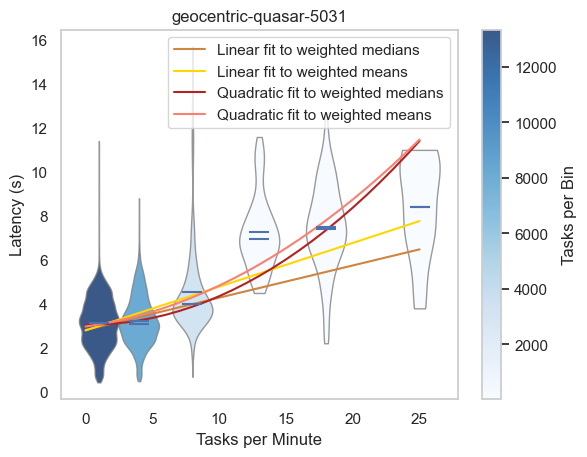

In [16]:
violin_density_binned_consistent('geocentric-quasar-5031')

## Iterate over all deployments

(This takes a long time to run.. there is probably a faster way to do the nested for loops that create the "tasks_mean" column?)

In [17]:
delete=[]
for index, key in enumerate(DepsDict):
    if len(DepsDict[key].DENSITY_BIN.unique())<2:
        print(DepsDict[key].DEPLOYMENT.iloc[0])
        delete.append(DepsDict[key].DEPLOYMENT.iloc[0])

for key in delete:
    del DepsDict[key]
    
print(len(DepsDict))

arithmetic-solstice-9332
new-bolide-0983
solar-perihelion-4667
telescopic-nadir-8081
meteoric-sky-5581
arithmetic-detector-5821
ancient-universe-1679
dense-nucleus-5042
sidereal-spacetime-5373
dynamical-frequency-9958
astral-kiloparsec-5355
asteroidal-ion-8192
sidereal-telescope-7235
transparent-spacecraft-9224
bitter-battery-2880
galactian-probe-8057
opaque-syzygy-0255
elementary-astronomy-5640
ultraviolet-albedo-0726
celestial-wormhole-6925
popular-satellite-1272
meteoric-eclipse-5679
184


quantile binning

In [127]:
for index, key in enumerate(DepsDict):
    
    if len(DepsDict[key].TASKS.unique()>10):
        DepsDict[key]['bins'] = pd.qcut(DepsDict[key]['TASKS'], q=10, duplicates='drop')
    
        tasks=(DepsDict[key].groupby('bins').mean()['TASKS'])
        bins_list = sorted(DepsDict[key].bins.unique())
        print(index, key)
        
        tasks_mean=[]
        for i in range(len(DepsDict[key])):
            for j in range(len(bins_list)):
                if (DepsDict[key].bins.iloc[i] == bins_list[j]):
                    tasks_mean.append(tasks[j])
        
        DepsDict[key]['tasks_mean'] = tasks_mean

0 meteoric-rotation-3453


KeyboardInterrupt: 

consistent binning for each deployment

In [18]:
for index, key in enumerate(DepsDict):

    tasks=[1,4,8,13,18,25,40,75,150, 300]
    bins_list=['a)   0 to   2 tasks', 'b)   3 to   5 tasks', 'c)   6 to  10 tasks', 'd)  11 to  15 tasks', 
               'e)  16 to  20 tasks', 'f)  21 to  30 tasks', 'g)  31 to  50 tasks', 'h)  51 to 100 tasks', 
               'i) 101 to 200 tasks', 'j) 200+ tasks']
    print(index, key)
    
    tasks_xrep=[]
    for i in range(len(DepsDict[key])):
        for j in range(len(bins_list)):
            if (DepsDict[key].DENSITY_BIN.iloc[i] == bins_list[j]):
                tasks_xrep.append(tasks[j])
    
    DepsDict[key]['tasks_xrep'] = tasks_xrep

0 frozen-gravity-7083
1 infrared-phase-9556
2 quasarian-isotope-3420
3 nuclear-aphelion-9880
4 universal-thermal-0806
5 native-universe-6259
6 lunar-nova-0800
7 galactian-blueshift-1932
8 empty-constellation-4854
9 devoid-instrument-0950
10 galactic-opposition-6262
11 asteroidic-perihelion-8158
12 modern-astronaut-3988
13 galactian-exoplanet-9992
14 heliocentric-opposition-9596
15 amateur-nebula-4648
16 extraterrestrial-albedo-7714
17 meteoroidal-equinox-0356
18 desolate-transit-7870
19 blazing-ray-3043
20 transparent-protoplanet-2691
21 gravitational-flux-5340
22 geostationary-detector-8447
23 energetic-wavelength-4450
24 lunar-amplitude-0815
25 cometary-antenna-7576
26 primitive-exploration-1721
27 blazing-telescope-3149
28 desolate-asteroid-3787
29 prehistoric-astronaut-6847
30 advanced-azimuth-0907
31 extragalactic-corona-5305
32 boreal-terminator-6336
33 exact-flux-5814
34 modern-apogee-6742
35 dense-asteroid-3585
36 elementary-astronaut-5472
37 traditional-protostar-8810
38 false

quantile binning

In [ ]:
fig = plt.figure(figsize=(25, 80))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

slopes=[]
ints=[]
slopes2=[]
ints2=[]

for index, key in enumerate(DepsDict_short):
    if (len(DepsDict_short[key].TASKS.unique()>10)): 

        #do the linear regression
        
        x = np.array(sorted(DepsDict_short[key].tasks_mean.unique())).reshape(-1, 1)
        y = DepsDict_short[key].groupby('bins').TASK_LATENCY.median()
        y2 = DepsDict_short[key].groupby('bins').TASK_LATENCY.mean()
        
        #x = np.array(DepsDict_short[key].TASKS).reshape(-1, 1)
        #y = DepsDict_short[key].TASK_LATENCY
        
        model_lr  = LinearRegression().fit(x,y)
        r_sq_lr = model_lr.score(x,y)
        intercept_lr = model_lr.intercept_
        slope_lr     = model_lr.coef_
        
        model_lr2  = LinearRegression().fit(x,y2)
        r_sq_lr2 = model_lr2.score(x,y2)
        intercept_lr2 = model_lr2.intercept_
        slope_lr2     = model_lr2.coef_
        
        # polynomial regression (2-degrees)
        x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
        model_poly     = LinearRegression().fit(x_,y)
        r_sq_poly      = model_poly.score(x_,y)
        intercept_poly = model_poly.intercept_
        slope_poly     = model_poly.coef_
        intercept_poly=float("{:.4f}".format(intercept_poly))
        slope_poly[0]=float("{:.4f}".format(slope_poly[0]))
        slope_poly[1]=float("{:.4f}".format(slope_poly[1]))
    
        xran = np.arange(np.max(DepsDict_short[key].tasks_mean.unique())+1)
        xran_sq = [i**2 for i in xran]
        y_poly = []
        for i in range(len(xran)):
            ys=[xran[i]*slope_poly[0]+xran_sq[i]*slope_poly[1]+intercept_poly]
            y_poly.append(ys)
        
        #slopes.append(slope_lr)
        #ints.append(intercept_lr)
        #slopes2.append(slope_lr2)
        #ints2.append(intercept_lr2)
        
        #plot regression line and data points
        ax = fig.add_subplot(20, 6, index+1)
        
        tasks=(DepsDict_short[key].groupby('bins').mean()['TASKS'])
        lats_array=np.array((DepsDict_short[key].groupby('bins').TASK_LATENCY.apply(list).reset_index()['TASK_LATENCY']))
        tasks_list=tasks.to_list()
        
        #sns.violinplot(x=DepsDict_short[key].tasks_mean, y=DepsDict_short[key].TASK_LATENCY, ax=ax)
        
        ax.violinplot(lats_array, tasks_list, showmeans=True, showmedians=True, widths=2)
        ax.scatter(x, y, marker='o', color='peru')
        ax.scatter(x, y2, marker='o', color='gold')
    
        ax.plot(xran, (xran)*slope_lr+intercept_lr, color='peru', label = 'median: y ='+str(slope_lr)[1:6]+'x+'+str(intercept_lr)[:4])
        ax.plot(xran, (xran)*slope_lr2+intercept_lr2, color='gold', label = 'mean: y ='+str(slope_lr2)[1:6]+'x+'+str(intercept_lr2)[:4])
        ax.plot(xran, y_poly, color = 'firebrick', label = 'quad: y ='+str(slope_poly[1])[:4]+'x^2+'+str(slope_poly[0])[:4]+'x+'+str(intercept_poly)[:4])

        ax.set_title(key+':')
        ax.set_ylabel('Median Latency')
        ax.set_xlabel('# of Tasks Per Minute')
        ax.legend()
    
    else: 
        ax = fig.add_subplot(20, 6, index+1)
        sns.violinplot(x=DepsDict_short[key].TASKS, y=DepsDict_short[key].TASK_LATENCY, ax=ax)
        ax.legend()

    
#plt.savefig('Figures/ViolinPlots_Celery_Feb22_binned_withfits.png')
#plt.savefig('Figures/ViolinPlots_Celery_Feb22_binned_withfits.pdf')
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

consistent binning

In [19]:
len(DepsDict)

184

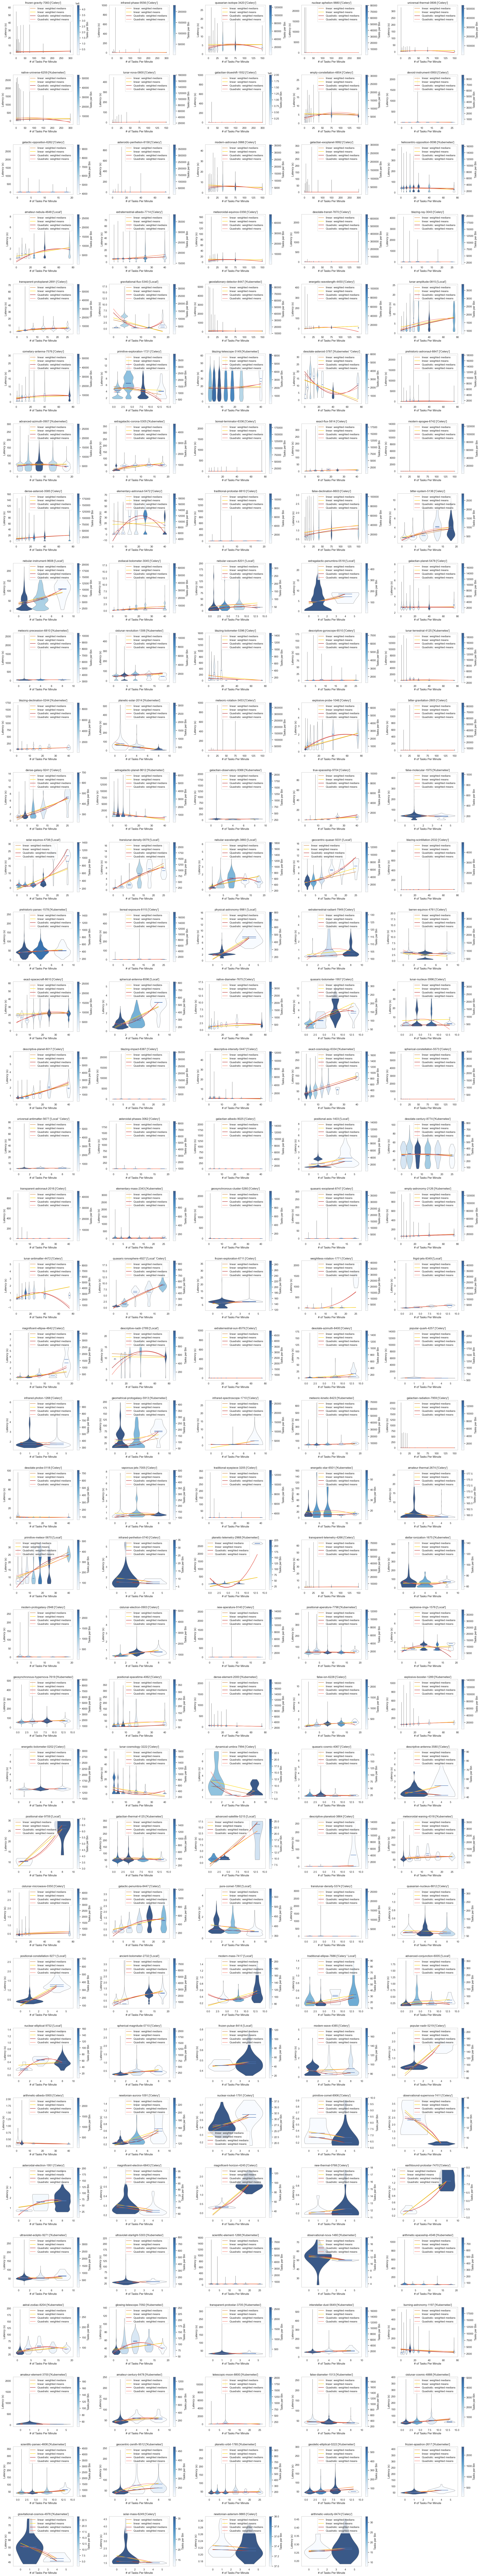

In [20]:
plt.rcParams['axes.grid'] = False
fig = plt.figure(figsize=(35, 250))
fig.subplots_adjust(hspace=0.4, wspace=0.28)

slopes=[]
slopes_wt=[]
slopes_wt2=[]
rs_lin=[]
rs_lin_wt=[]
rs_lin_wt2=[]
rs_poly=[]

for index, key in enumerate(DepsDict):
    
    
    #do the linear regression
    x = np.array(sorted(DepsDict[key].tasks_xrep.unique())).reshape(-1, 1)
    x_all = np.array(DepsDict[key].TASKS).reshape(-1, 1)
    y = (DepsDict[key].groupby('DENSITY_BIN').TASK_LATENCY.median())
    y2 = (DepsDict[key].groupby('DENSITY_BIN').TASK_LATENCY.mean())
    y_all = DepsDict[key].TASK_LATENCY
    sample_weight = DepsDict[key].groupby('DENSITY_BIN').size().to_list()
    
    #linear regression - all data points
    model_lr_all  = LinearRegression().fit(x_all,y_all)
    r_sq_lr_all = model_lr_all.score(x_all,y_all)
    intercept_lr_all = model_lr_all.intercept_
    slope_lr_all     = model_lr_all.coef_
    slopes.append(slope_lr_all)
    rs_lin.append(r_sq_lr_all)
    
    #linear regression - weighted medians
    model_lr_wt  = LinearRegression().fit(x,y, sample_weight)
    r_sq_lr_wt = model_lr_wt.score(x,y, sample_weight)
    intercept_lr_wt = model_lr_wt.intercept_
    slope_lr_wt     = model_lr_wt.coef_
    slopes_wt.append(slope_lr_wt)
    rs_lin_wt.append(r_sq_lr_wt)
    
    #linear regression - weighted means
    model_lr_wt2  = LinearRegression().fit(x,y2, sample_weight)
    r_sq_lr_wt2 = model_lr_wt2.score(x,y2, sample_weight)
    intercept_lr_wt2 = model_lr_wt2.intercept_
    slope_lr_wt2     = model_lr_wt2.coef_
    slopes_wt2.append(slope_lr_wt2)
    rs_lin_wt2.append(r_sq_lr_wt2)
    
    # polynomial regression (2-degrees)
    x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_all)
    model_poly     = LinearRegression().fit(x_,y_all)
    r_sq_poly      = model_poly.score(x_,y_all)
    intercept_poly = model_poly.intercept_
    slope_poly     = model_poly.coef_
    intercept_poly=float("{:.5f}".format(intercept_poly))
    slope_poly[0]=float("{:.5f}".format(slope_poly[0]))
    slope_poly[1]=float("{:.5f}".format(slope_poly[1]))
    rs_poly.append(r_sq_poly)
    
    # polynomial regression (2-degrees, on weighted medians)
    x2_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
    model_poly2     = LinearRegression().fit(x2_,y, sample_weight)
    r_sq_poly2      = model_poly2.score(x2_,y)
    intercept_poly2 = model_poly2.intercept_
    slope_poly2     = model_poly2.coef_
    
    # polynomial regression (2-degrees, on weighted means)
    x3_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
    model_poly3     = LinearRegression().fit(x3_,y2, sample_weight)
    r_sq_poly3      = model_poly3.score(x3_,y2)
    intercept_poly3 = model_poly3.intercept_
    slope_poly3     = model_poly3.coef_

    xran = np.arange(np.max(DepsDict[key].tasks_xrep.unique())+1)
    xran_sq = [i**2 for i in xran]
    y_poly = []
    for i in range(len(xran)):
        ys=[xran[i]*slope_poly[0]+xran_sq[i]*slope_poly[1]+intercept_poly]
        y_poly.append(ys)
        
    y_poly2 = []
    for i in range(len(xran)):
        ys2=[xran[i]*slope_poly2[0]+xran_sq[i]*slope_poly2[1]+intercept_poly2]
        y_poly2.append(ys2)
        
    y_poly3 = []
    for i in range(len(xran)):
        ys3=[xran[i]*slope_poly3[0]+xran_sq[i]*slope_poly3[1]+intercept_poly3]
        y_poly3.append(ys3)
    
    #plot regression line and data points
    ax = fig.add_subplot(47, 5, index+1)
    
    lats_array=np.array((DepsDict[key].groupby('DENSITY_BIN').TASK_LATENCY.apply(list).reset_index()['TASK_LATENCY']))
    tasks_list = sorted(DepsDict[key].tasks_xrep.unique())
    
    #ax.plot(xran, (xran)*slope_lr_all+intercept_lr_all, color='black', label = 'Linear fit to all points')
    ax.plot(xran, (xran)*slope_lr_wt+intercept_lr_wt, color='peru', label = 'linear: weighted medians')
    ax.plot(xran, (xran)*slope_lr_wt2+intercept_lr_wt2, color='gold', label = 'linear: weighted means')
    densities = (DepsDict[key].groupby('DENSITY_BIN').size()).to_list()
    #ax.plot(xran, y_poly, color = 'gray', label = 'Quadratic fit to all points')
    plt.plot(xran, y_poly2, color = 'firebrick', label = 'Quadratic: weighted medians')
    plt.plot(xran, y_poly3, color = 'salmon', label = 'Quadratic: weighted means')
    cmap = plt.get_cmap('Blues')
    violins = ax.violinplot(lats_array, tasks_list, showmeans=True, showmedians=True, showextrema=False, widths=3)
    norm = plt.Normalize(np.min(densities), np.max(densities))
    for violin, dens in zip(violins['bodies'], densities):
        violin.set_color(cmap(norm(dens)))
        violin.set_alpha(0.8)
        violin.set_edgecolor('gray')
    plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), alpha=violin.get_alpha(), label='Tasks per Bin', ax=ax)
    ax.set_title(key+':'+str(DepsDict[key].EXECUTOR.unique()))
    #plt.ylim(0.0,np.quantile(DepsDict[key]['TASK_LATENCY'], 0.99))
    ax.set_ylabel('Latency (s)')
    ax.set_xlabel('# of Tasks Per Minute')
    ax.legend()
    
plt.savefig('Figures/ViolinPlots_Celery_Jan22_binned_colormap2.png')
plt.savefig('Figures/ViolinPlots_Celery_Jan22_binned_colormap2.pdf')
plt.show()

In [21]:
slopes_float = [float(i) for i in slopes]
slopes_wt_float = [float(i) for i in slopes_wt]
slopes_wt2_float = [float(i) for i in slopes_wt2]
slopes_wt_float, slopes_wt2_float

([0.0041204201616811455,
  0.01259491503853858,
  0.0034048515988632172,
  0.013182199002321673,
  0.023673174492313747,
  0.12631048915871304,
  0.010672771773253263,
  0.005155592417825344,
  -0.003901885616909612,
  0.24693988509164008,
  0.28680368968471703,
  0.0060193538763678375,
  -0.006229111081591501,
  0.0011905527781377622,
  -0.048547353429379964,
  0.02186668912108288,
  0.08488538329811281,
  -0.003221821084066508,
  0.007501754036845704,
  0.2121598907487927,
  0.1499115117972698,
  -0.2566409535332034,
  0.22568831575241036,
  0.14977095821353278,
  0.08347752704242654,
  0.01710540744425189,
  -0.19079909713818285,
  0.0361465203813363,
  -0.20221724080135087,
  0.5931586228093645,
  0.15914090120302443,
  3.221879455228965,
  0.0015297029970793648,
  0.2376073436946004,
  0.002713937983057935,
  0.15059992968304714,
  -0.31125228570901403,
  0.1510653210155615,
  0.002538854789316265,
  0.11154631606294255,
  7.715782620151434,
  0.020777602754463956,
  1.55043664292

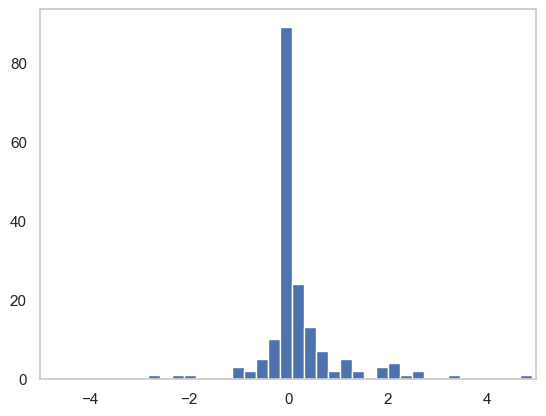

In [22]:
plt.hist(slopes_wt2_float, bins=500)
plt.xlim(-5,5)
plt.show()

In [26]:
len(slopes_wt2_float)
pos_slope_wt2 = [i for i in slopes_wt2_float if i>0]
pos_slope_wt = [i for i in slopes_wt_float if i>0]
print('Percentage of positive linear slopes (medians): '+str(len(pos_slope_wt)/len(slopes_wt_float)*100)[:4]+'%')
print('Percentage of positive linear slopes (means): '+str(len(pos_slope_wt2)/len(slopes_wt2_float)*100)[:4]+'%')
print(np.median(slopes_wt2_float))

Percentage of positive linear slopes (medians): 77.1%
Percentage of positive linear slopes (means): 68.4%
0.028681073263022515


0.7657113799515798
22


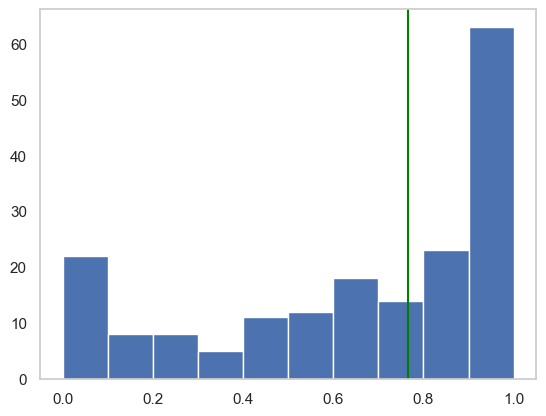

In [27]:
plt.hist(rs_lin_wt)
plt.axvline(x=np.median(rs_lin_wt), color='green')
print(np.median(rs_lin_wt))
print(len([i for i in rs_lin_wt if i<0.1]))

0.0858284208464487
90


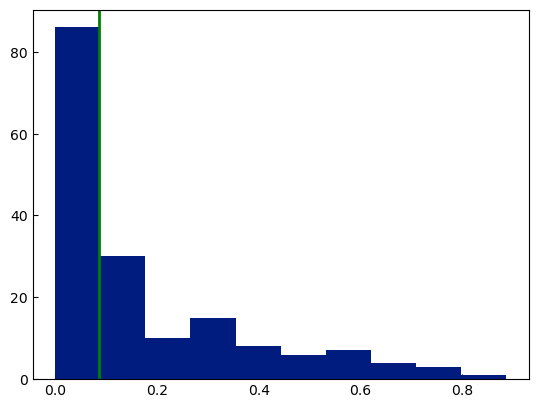

In [241]:
plt.hist(rs_poly)
plt.axvline(x=np.median(rs_poly), color='green')
print(np.median(rs_poly))
print(len([i for i in rs_poly if i<0.1]))

(-5.0, 5.0)

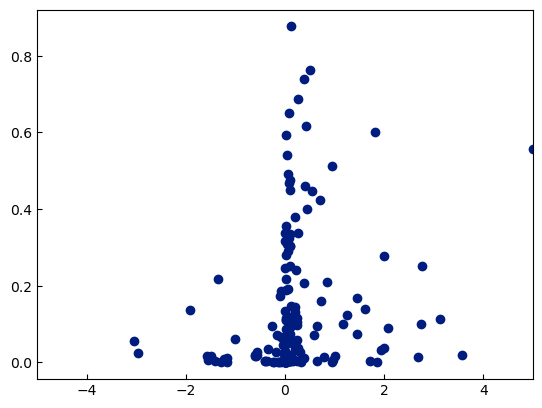

In [236]:
plt.scatter(slopes_float, rs_lin)
plt.xlim(-5,5)